# Обработка текстов на естественном языке: задача классификации

## Подготовка данных для использования в обучении модели

### Импорт пакетов и загрузка данных

In [1]:
import string
import time

import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer

In [2]:
data = pd.read_csv('./author_data.csv', encoding='utf8')
print(data.head())

                                                text       author
0  Вы не знаете, как вы для меня важны и как вы м...      Толстой
1  14)..    Однако эта часть мемуаров не была про...      Толстой
2  Он прибежал из леса к опушке и, бледный, с рас...        Чехов
3  — сказала мать, притворно сердито отталкивая д...      Толстой
4  Вечер проектировался, однако же, запросто; ожи...  Достоевский


In [3]:
text = list(data['text'].values)
author = list(data['author'].values)

print('Датасет содержит {} записей.'.format(len(text)))

Датасет содержит 54000 записей.


### Исследование данных

#### Количество записей для каждого автора:

In [4]:
authors = Counter(author)
authors

Counter({'Толстой': 18000, 'Чехов': 18000, 'Достоевский': 18000})

In [5]:
author_names = list(authors.keys())
author_names

['Толстой', 'Чехов', 'Достоевский']

Посмотрим на некоторые примеры предложений:

In [6]:
np.random.seed(73)
n = len(text)

for _ in range(5):
    print(text[np.random.randint(0, n)])

Ты никогда и понять не мог, как бы ты в ее глазах интересен стал, если бы с твердостью и гордостью умел переносить нашу обстановку.
С Софочкой посидит Протопопов, Михаил Иваныч, а Бобика пусть покатает Андрей Сергеич.
Извини, я тоже не понимаю….
Раз в два-три месяца она уезжала из С. и говорила мужу, что едет посоветоваться с профессором насчет своей женской болезни, – и муж верил и не верил.
И появились у меня слезы на глазах, и я был доволен, что он это приметил.


#### Расчёт статистики по словам:

In [7]:
word_count = np.array([len(sent.split()) for sent in text])
char_count = np.array([len(sent) for sent in text])
ave_length = char_count / word_count

In [8]:
def get_stats(var):    
    print('\tМин: ', np.min(var))
    print('\tМакс: ', np.max(var))
    print('\tСреднее: ', np.mean(var))
    print('\tМедианное: ', np.median(var))
    print('\tПерцентиль 1%: ', np.percentile(var, 1))
    print('\tПерцентиль 95%: ', np.percentile(var, 95))
    print('\tПерцентиль 99%: ', np.percentile(var, 99))
    print('\tПерцентиль 99.5%: ', np.percentile(var, 99.5))
    print('\tПерцентиль 99.9%: ', np.percentile(var, 99.9))

In [9]:
print('Статистика количества слов:')
get_stats(word_count)

Статистика количества слов:
	Мин:  1
	Макс:  323
	Среднее:  16.358851851851853
	Медианное:  11.0
	Перцентиль 1%:  1.0
	Перцентиль 95%:  49.0
	Перцентиль 99%:  82.0
	Перцентиль 99.5%:  96.0
	Перцентиль 99.9%:  136.00100000000384


**Покажем на графике**

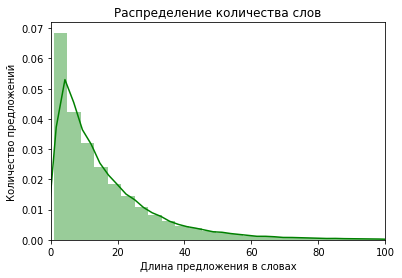

In [10]:
sns.distplot(word_count, kde=True, bins=80, color='green').set_title('Распределение количества слов')
plt.xlabel('Длина предложения в словах')
plt.ylabel('Количество предложений')
plt.xlim(0, 100)
plt.savefig('word_count.png')

In [11]:
print('Статистика по количеству символов:')
get_stats(char_count)

Статистика по количеству символов:
	Мин:  5
	Макс:  2042
	Среднее:  101.24883333333334
	Медианное:  67.0
	Перцентиль 1%:  6.0
	Перцентиль 95%:  309.0
	Перцентиль 99%:  523.0
	Перцентиль 99.5%:  618.0
	Перцентиль 99.9%:  893.0020000000077


**Покажем на графике**

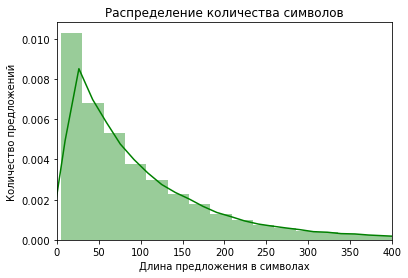

In [12]:
sns.distplot(char_count, kde=True, bins=80, color='green').set_title('Распределение количества символов')
plt.xlabel('Длина предложения в символах')
plt.ylabel('Количество предложений')
plt.xlim(0, 400)
plt.savefig('char_count.png')

In [13]:
print('Статистика по средней длине:')
get_stats(ave_length)

Статистика по средней длине:
	Мин:  2.3333333333333335
	Макс:  18.0
	Среднее:  6.112017234243191
	Медианное:  6.022222222222222
	Перцентиль 1%:  3.0
	Перцентиль 95%:  8.125
	Перцентиль 99%:  10.0
	Перцентиль 99.5%:  11.0
	Перцентиль 99.9%:  13.0


**Покажем на графике**

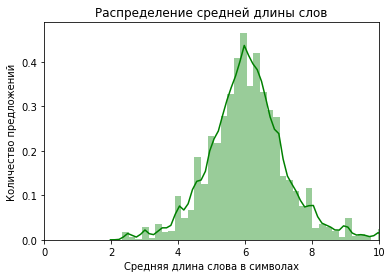

In [14]:
sns.distplot(ave_length, kde=True, bins=80, color='green').set_title('Распределение средней длины слов')
plt.xlabel('Средняя длина слова в символах')
plt.ylabel('Количество предложений')
plt.xlim(0, 10)
plt.savefig('ave_length.png')

#### Исследование выбросов в данных

Посмотрим на необычно длинные предложения:

In [15]:
word_outliers = np.where(word_count > 150)

for i in word_outliers[0][:5]:
    print('Автор: {}, Длина: {}'.format(author[i], word_count[i]))
    print(text[i], '\n')

Автор: Толстой, Длина: 163
И вот тогда-то я ложился на свою постель, лицом к саду, и, закрывшись, сколько возможно было, от комаров и летучих мышей, смотрел в сад, слушал звуки ночи и мечтал о любви и счастии.. Тогда все получало для меня другой смысл: и вид старых берез, блестевших с одной стороны на лунном небе своими кудрявыми ветвями, с другой – мрачно застилавших кусты и дорогу своими черными тенями, и спокойный, пышный, равномерно, как звук, возраставший блеск пруда, и лунный блеск капель росы на цветах перед галереей, тоже кладущих поперек серой рабатки свои грациозные тени, и звук перепела за прудом, и голос человека с большой дороги, и тихий, чуть слышный скрип двух старых берез друг о друга, и жужжание комара над ухом под одеялом, и падение зацепившегося за ветку яблока на сухие листья, и прыжки лягушек, которые иногда добирались до ступеней террасы и как-то таинственно блестели на месяце своими зеленоватыми спинками, – все это получало для меня странный смысл– смысл слишком

In [16]:
max_authors = {author : 0 for author in author_names}

for i in word_outliers[0]:
    max_authors[author[i]] += 1

Counter(max_authors)

Counter({'Толстой': 28, 'Чехов': 3, 'Достоевский': 3})

И на необычно короткие (относительно необычно, т.к. их очень много):

In [17]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0][:10]:
    print('Длина предложения: {}'.format(word_count[i]))
    print(text[i], '\n')

Длина предложения: 1
Благодарю! 

Длина предложения: 1
XVII. 

Длина предложения: 1
Гм!.. 

Длина предложения: 1
(Уходит.). 

Длина предложения: 1
(Задумчиво.) 

Длина предложения: 1
Опомнитесь! 

Длина предложения: 1
Соленый. 

Длина предложения: 1
Ирина. 

Длина предложения: 1
Идем!... 

Длина предложения: 1
1812». 



#### Исследование символов

Создадим словарь, показывающий количество включений в датасет для каждого символа.

In [18]:
text_string = ''
for sents in text:
    text_string += sents.lower()

char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt), 'необычных символов в данных.')

Counter({' ': 864226, 'о': 477309, 'е': 364014, 'а': 345020, 'и': 283125, 'н': 272813, 'т': 260609, 'с': 223816, 'л': 201825, 'в': 194024, 'р': 177444, 'к': 143552, 'м': 133164, 'д': 132447, ',': 121669, 'у': 119228, 'п': 112185, 'я': 94497, '.': 89064, 'ь': 85046, 'г': 81459, 'ы': 78234, 'б': 74083, 'ч': 69984, 'з': 69483, 'й': 47080, 'ж': 46697, 'ш': 38729, 'х': 35901, 'ю': 26709, '—': 15544, 'ц': 14322, '\xa0': 13565, 'э': 12846, 'щ': 12753, '–': 12646, '-': 9663, '!': 9533, 'ф': 8056, '?': 7239, 'e': 5894, ';': 5235, '…': 4573, ':': 4565, 'i': 3963, '«': 3871, '»': 3826, 'a': 3029, 's': 2990, 'n': 2799, '1': 2538, ')': 2510, '(': 2480, 'r': 2460, '2': 2381, 'o': 2365, 'u': 2196, 't': 2156, '3': 2002, 'l': 1970, 'm': 1914, 'ё': 1643, 'c': 1342, '8': 1327, 'ъ': 1275, 'd': 1193, '6': 993, 'v': 977, '4': 965, 'p': 928, '5': 855, '7': 816, '[': 780, ']': 780, '0': 751, '&': 732, '#': 731, '9': 681, 'h': 600, 'b': 497, 'x': 445, '*': 440, "'": 430, 'f': 414, 'q': 392, 'g': 359, 'j': 292,

Все используемые символы:

In [19]:
print(list(char_cnt.keys()))

['в', 'ы', ' ', 'н', 'е', 'з', 'а', 'т', ',', 'к', 'д', 'л', 'я', 'м', 'ж', 'и', 'о', 'г', 'с', '!', '.', '1', '4', ')', 'э', 'ч', 'ь', 'у', 'р', 'б', 'п', 'щ', 'ц', 'й', 'х', 'ю', '«', '»', '(', 'ш', '-', '—', ';', '?', ':', '–', 'ъ', 'ф', '6', '8', '\xa0', 'x', 'v', 'i', '…', '7', '0', '2', '3', '9', 'm', 'e', 's', 't', 'a', '&', '#', '5', 'l', 'ё', 'r', '{', '}', 'n', 'o', 'z', 'u', 'q', 'c', 'h', '\x7f', '“', 'p', 'd', 'j', '’', 'b', 'é', '[', ']', 'g', 'f', "'", 'y', '́', '*', '„', '№', 'ó', '>', 'k', 'ô', '%', 'w', '<', '̀', 'ö', 'ê', 'à', 'è', '/', '”', '\t', '"', 'ç', 'ù', '¾', 'â', 'û', '°', '`', 'ü', 'á', 'і', 'ï', 'î', 'ä', '‑']


Среди них есть много тех, которые не относятся к стандартным, к знакам пунктуации или кириллицы. Выделим те предложения, в которых они встречаются.

In [20]:
accented_chars = ['f', 'u', 'r', 's', 'i', 'c', 'h', '́', 'n', 'd', 'p', 'e', 'a', 't', 'o', 'l', 'x', 'm', 'j', 'é', 'ô', 'v', 'q', 'ê', 'g', 'b', 'k', 'y', 'à', 'і', 'z', 'w', 'è', 'ó', 'ö', '°', 'ç', 'ï', 'á', 'ü', 'ù', 'û', 'î', 'ѣ', 'â']

accented_text = []
for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print(len(accented_text), 'предложений содержат нестандартные символы.')

1755 предложений содержат нестандартные символы.


In [21]:
for i in accented_text[:10]:
    print('Предложение номер {}: '.format(i))
    print(text[i], '\n')

Предложение номер 16389: 
Он тотчас же и горячо схватил меня за руку..     – Enfin un ami! 

Предложение номер 32775: 
[68] — говорит другой черный, с итальянским выговором, подходя к нашим..     — Кафтан бун, — говорит бойкий солдат, рассматривая шитые полы зуава, и опять смеются..     — Ne sortez pas de la ligne, &#224; vos places, sacr&#233; nom……[69] — кричит французский капрал, и солдаты с видимым неудовольствием расходятся..     А вот в кружке французских офицеров наш молодой кавалерийский офицер так и рассыпается французским парикмахерским жаргоном. 

Предложение номер 40967: 
– Ну что́?. 

Предложение номер 8202: 
Устав был очень длинен, и Пьер от радости, волнения и стыда не был в состоянии понимать того, что́ читали. 

Предложение номер 16394: 
Blanche du-Placet! 

Предложение номер 8212: 
Самый habitus 2 романа, его физиономию. 

Предложение номер 16424: 
Восторженное состояние его еще усилилось при виде девочки, которую он спас..      — Ce qu'elle dit? 

Предложение номер 1

На основании приведённых выше исследований предложений можно сказать, что наши данные вполне в пригодном для анализа состоянии. Единственное что, необходимо удалить блоки с отступами и некоторые недопустимые символы, являющиеся артефактами исходного текста.

## Подготовка данных

Как раз таки тут и удаляем недопустимые неинформативные символы.

In [22]:
text = [excerpt.replace('\xa0', '').replace('\x7f', '') for excerpt in text]

И большие блоки отступов.

In [23]:
ctr = 0
for excerpt in text:
    if '  ' in excerpt:
        ctr += 1

print(ctr, 'вхождений больших блоков отступов.')

8083 вхождений больших блоков отступов.


In [24]:
new_text = []
for excerpt in text:
    while '  ' in excerpt:
        excerpt = excerpt.replace('  ',' ')
    new_text.append(excerpt)

text = new_text
print(len(text))

54000


Удаляем пунктуацию и приводим все буквы предложения к строчным.

In [25]:
normed_text = []

for sent in text:
    new = sent.lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '') # английские кавычки
    new = new.replace('‟', '').replace('”', '') # французские кавычки
    new = new.replace('«', '').replace('»', '') # кавычки-ёлочки
    new = new.replace('—', '').replace('–', '') # длинное тире
    new = new.replace('(', '').replace(')', '')
    new = new.replace('…', '') # многоточие одним символом
    
    normed_text.append(new)
    
print(normed_text[0:5])
print(len(normed_text))

['вы не знаете как вы для меня важны и как вы много для меня сделали', '14 однако эта часть мемуаров не была пропущена цензурой при их первой публикации совпадающей с периодом работы толстого над войной и миром см', 'он прибежал из леса к опушке и бледный с расширенными зрачками хотел чтото сказать но одышка и волнение долго мешали ему говорить', ' сказала мать притворно сердито отталкивая дочь', 'вечер проектировался однако же запросто ожидались одни только друзья дома в самом малом числе']
54000


Сохраняем подготовленные данные.

In [26]:
data['text'] = normed_text

data.to_csv('preprocessed_data.csv', index=False)